# Tutorial: Data-Driven Proposals in Gen

This tutorial introduces you to an important inference programming feature in Gen --- using custom "data-driven" proposals to accelerate Monte Carlo inference. Data-driven proposals use information in the observed data set to choose the proposal distibution for latent variables in a generative model. Data-driven proposals can have trainable parameters that are trained data simulated from a generative model to improve their efficacy. This training process is sometimes called 'amortized inference' or 'inference compilation'.

We focus on using data-driven proposals with importance sampling, which is one of the simpler classes of Monte Carlo inference algorithms. Data-driven proposals can also be used with Markov Chain Monte Carlo (MCMC) and sequential Monte Carlo (SMC), but these are not covered in this tutorial.

This tutorial builds on a probabilistic model for the motion of an autonomous agent that was introduced in the [introduction to modeling tutorial](https://github.com/probcomp/gen-examples/tree/master/tutorial-modeling-intro). We show that we can improve the efficiency of inference in this model using two types of custom proposals for the destination of the agent: First, we write a hand-coded data-driven proposal with a single parameter that we tune using amortized inference. Second, we write a data-driven proposal based on a deep neural network, which we also train using amortized inference. We show an implementation of the neural-network based proposal using the built-in modeling language, and then an implementation using the TensorFlow modeling DSL.

Data-driven proposals that are trained on simulated data can be seen from two perspectives: For practitioners of inference in generative models, they can be seen as peforming amortized Bayesian inference in the generative model, by learning an improved approximation to the conditional distribution on latent variables given observations. Practitioners of supervised machine learning may view amortized inference training procedure as training the model on simulated data. By writing the data simulator in a probabilistic programming language, the supervised machine learning practitioner gets the extra ability to embed the learned inference model in Monte Carlo algorithms, which can assist with robustness and accuracy.

## Outline

**Section 1.** [Recap on the generative model of an autonomous agent](#model-recap)

**Section 2.** [Writing a data-driven proposal as a generative function](#custom-proposal)

**Section 3.** [Using a data-driven proposal within importance sampling](#custom-proposal)

**Section 4.** [Training the parameters of a data-driven proposal](#custom-proposal)

**Section 5.** [Writing and training a deep-learning based data-driven proposal](#deep)

**Section 6.** [Writing a data-driven proposal that uses TensorFlow](#tf)

In [1]:
using Gen
using GenViz
using PyPlot
using JLD

┌ Info: Recompiling stale cache file /home/marcoct/.julia/compiled/v1.0/Gen/OEZG1.ji for Gen [ea4f424c-a589-11e8-07c0-fd5c91b9da4a]
└ @ Base loading.jl:1190


In [2]:
viz_server = VizServer(8090)
sleep(1)

## 1: Recap on the generative model of an autonomous agent   <a name="model-recap"></a>

We begin by loading the source files for the generative model of an autonomous agent that was introduced in a previous tutorial:

In [3]:
include("../inverse-planning/geometric_primitives.jl");
include("../inverse-planning/scene.jl");
include("../inverse-planning/planning.jl");

We redefine the generative model:

In [4]:
@gen function agent_model(scene::Scene, dt::Float64, num_ticks::Int, planner_params::PlannerParams)

    # sample the start point of the agent from the prior
    start_x = @addr(uniform(0, 1), :start_x)
    start_y = @addr(uniform(0, 1), :start_y)
    start = Point(start_x, start_y)

    # sample the destination point of the agent from the prior
    dest_x = @addr(uniform(0, 1), :dest_x)
    dest_y = @addr(uniform(0, 1), :dest_y)
    dest = Point(dest_x, dest_y)

    # plan a path that avoids obstacles in the scene
    maybe_path = plan_path(start, dest, scene, planner_params)
    planning_failed = maybe_path == nothing
    
    # sample the speed from the prior
    speed = @addr(uniform(0.3, 1), :speed)

    if planning_failed
        
        # path planning failed, assume the agent stays as the start location indefinitely
        locations = fill(start, num_ticks)
    else
        
        # path planning succeeded, move along the path at constant speed
        locations = walk_path(maybe_path, speed, dt, num_ticks)
    end

    # generate noisy measurements of the agent's location at each time point
    noise = 0.01
    for (i, point) in enumerate(locations)
        x = @addr(normal(point.x, noise), :meas => (i, :x))
        y = @addr(normal(point.y, noise), :meas => (i, :y))
    end

    return (planning_failed, maybe_path)
end;

And we redefine a function that converts a trace of this model into a value that is easily serializable to JSON, for use with the GenViz visualization framework:

In [5]:
function trace_to_dict(trace)
    args = Gen.get_args(trace)
    (scene, dt, num_ticks, planner_params) = args
    choices = Gen.get_assmt(trace)
    (planning_failed, maybe_path) = Gen.get_retval(trace)

    d = Dict()

    # scene (the obstacles)
    d["scene"] = scene

    # the points along the planned path
    if planning_failed
        d["path"] = []
    else
        d["path"] = maybe_path.points
    end

    # start and destination location
    d["start"] = Point(choices[:start_x], choices[:start_y])
    d["dest"] = Point(choices[:dest_x], choices[:dest_y])

    # the observed location of the agent over time
    local measurements
    measurements = Vector{Point}(undef, num_ticks)
    for i=1:num_ticks
        measurements[i] = Point(choices[:meas => (i, :x)], choices[:meas => (i, :y)])
    end
    d["measurements"] = measurements

    return d
end;

We redefine a scene:

In [7]:
scene = Scene(0, 1, 0, 1)
add_obstacle!(scene, make_square(Point(0.30, 0.20), 0.1))
add_obstacle!(scene, make_square(Point(0.83, 0.80), 0.1))
add_obstacle!(scene, make_square(Point(0.80, 0.40), 0.1))
horizontal = false
vertical = true
wall_thickness = 0.02
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_line(vertical, Point(0.60, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_line(horizontal, Point(0.60 - 0.15, 0.80), 0.15 + wall_thickness, wall_thickness))
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.80), 0.15, wall_thickness))
add_obstacle!(scene, make_line(vertical, Point(0.20, 0.40), 0.40, wall_thickness));

We will assume the agent starts in the lower left-hand corner. And we will assume particular parameters for the planning algorithm that the agent uses. We will also assume that there are 10 measurements, separated `0.1` time units.

In [8]:
start = Point(0.1, 0.1)
dt = 0.1
num_ticks = 10
planner_params = PlannerParams(300, 3.0, 2000, 1.);

We will infer the destination of the agent for the given sequence of observed locations:

In [9]:
measurements = [
    Point(0.0980245, 0.104775),
    Point(0.113734, 0.150773),
    Point(0.100412, 0.195499),
    Point(0.114794, 0.237386),
    Point(0.0957668, 0.277711),
    Point(0.140181, 0.31304),
    Point(0.124384, 0.356242),
    Point(0.122272, 0.414463),
    Point(0.124597, 0.462056),
    Point(0.126227, 0.498338)];

We redefine the generic importance sampling algorithm that we used in the previous notebook:

In [52]:
function do_inference(scene::Scene, dt::Float64, num_ticks::Int, planner_params::PlannerParams, start::Point,
                      measurements::Vector{Point}, amount_of_computation::Int)
    
    # Create an "Assignment" that maps model addresses (:y, i)
    # to observed values ys[i]. We leave :slope and :intercept
    # unconstrained, because we want them to be inferred.
    observations = Gen.DynamicAssignment()
    observations[:start_x] = start.x
    observations[:start_y] = start.y
    for (i, m) in enumerate(measurements)
        observations[:meas => (i, :x)] = m.x
        observations[:meas => (i, :y)] = m.y
    end
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (trace, _) = Gen.importance_resampling(agent_model, (scene, dt, num_ticks, planner_params),
        observations, amount_of_computation)
    
    return trace
end;

Below, we run this algorithm 1000 times, to generate 1000 approximate samples from the posterior distribution on the destination. The inferred destinations should appear as red dots on the map. First, we abstract this into a function.

In [53]:
function visualize_inference(measurements, scene, start; computation_amt=50, samples=1000)
    info = Dict("measurements" => measurements, "scene" => scene, "start" => start)
    viz = Viz(viz_server, joinpath(@__DIR__, "../inverse-planning/overlay-viz/dist"), info)
    openInNotebook(viz)
    sleep(5)
    for i=1:samples
        trace = do_inference(scene, dt, num_ticks, planner_params, start, measurements, computation_amt)
        putTrace!(viz, i, trace_to_dict(trace))
    end
    displayInNotebook(viz)
end;

In [54]:
visualize_inference(measurements, scene, start, computation_amt=50, samples=1000)

<!----> <!----><!----><!---->

## 2. Writing a data-driven proposal as a generative function <a name="custom-proposal"></a>

The inference algorithm above used a variant of [`Gen.importance_resampling`](https://probcomp.github.io/Gen/dev/ref/inference/#Gen.importance_resampling) that does not take a custom proposal distribution. It uses the default proposal distribution associated with the generative model. For generative functions defined using the built-in modeling DSL, the default proposal distribution is based on *ancestral sampling*, which involves sampling unconstrained random choices from the distributions specified in the generative mode.

We can sample from the default proposal distribution using `Gen.initialize`. The cell below shows samples of the destination from this distribution.

In [11]:
info = Dict("measurements" => measurements, "scene" => scene, "start" => start)
viz = Viz(viz_server, joinpath(@__DIR__, "../inverse-planning/overlay-viz/dist"), info)
for i=1:1000
    (trace, _) = Gen.initialize(agent_model, (scene, dt, num_ticks, planner_params))
    putTrace!(viz, i, trace_to_dict(trace))
end
displayInNotebook(viz)

<!----> <!----><!----><!---->

Intuitively, if we see the data set above (where blue is the starting location), we might guess that the agent is more likely to be heading into the upper part of the scene. This is because we don't expect the agent to unecessarily backtrack on its route to its destnation. A simple heuristic for biasing the proposal distribution of the destination using just the first measurement and the last measurement might be:

- If the x-coordinate of the last measurement is greater than the x-coordinate of the first measurement, we think the agent is probably headed generally to the right. Make values `:dest_x` that are greater than the x-coordinate of the last measurement more probable.

- If the x-coordinate of the last measurment is less than the x-coordinate of the first measurement, we think the agent is probably headed generally to the left. Make values  `:dest_x` that are smaller than the x-coordinate of the last measurement more probable.

We can apply the same heuristic separately for the y-coordinate.

To implement this idea, we discretize the x-axis and y-axis of the scene into bins:

In [12]:
num_x_bins = 5
num_y_bins = 5;

We will propose the x-coordinate of the destination from a [piecewise_uniform](https://probcomp.github.io/Gen/dev/ref/distributions/#Gen.piecewise_uniform) distribution, where we set higher probability for certain bins based on the heuristic described above and use a uniform continuous distribution for the coordinate within a bin. The `compute_bin_probs` function below computes the probability for each bin. The bounds of the scene are given by `min` and `max`. The coordinates of the first and last measured points respectively are given by `first` and `last`. We compute the probability by assigning a "score" to each bin based on the heuristic above --- if the bin should receive lower probability, it gets a score of 1., and if it should receive higher probability, it gets a bin of `score_high`, where `score_high` is some value greater than 1.

In [13]:
function compute_bin_prob(first::Float64, last::Float64, bin::Int, last_bin::Int, score_high)
    last >= first && bin >= last_bin && return score_high
    last < first && bin <= last_bin && return score_high
    return 1.
end

function compute_bin_probs(num_bins::Int, min::Float64, max::Float64, first::Float64, last::Float64, score_high)
    bin_len = (max - min) / num_bins
    last_bin = Int(floor(last / bin_len)) + 1
    probs = [compute_bin_prob(first, last, bin, last_bin, score_high) for bin=1:num_bins]
    total = sum(probs)
    return [p / total for p in probs]
end;

We will see how to automatically tune the value of `score_high` shortly. For now, we will use a value of 5. Below, we see that for the data set of measurements, shown above the probabilities of higher bins are indeed 5x larger than those of lower bins, becuase the agent seems to be headed up. 

In [14]:
compute_bin_probs(num_y_bins, scene.ymin, scene.ymax, measurements[1].y, measurements[end].y, 5.)

5-element Array{Float64,1}:
 0.058823529411764705
 0.058823529411764705
 0.29411764705882354 
 0.29411764705882354 
 0.29411764705882354 

Next, we write a generative function that applies this heuristic for both the x-coordinate and y-coordinate, and samples the destination coordinates at addresses `:dest_x` and `:dest_y`.

In [15]:
@gen function custom_dest_proposal(measurements::Vector{Point}, scene::Scene)

    score_high = 5.
    
    x_first = measurements[1].x
    x_last = measurements[end].x
    y_first = measurements[1].y
    y_last = measurements[end].y
    
    # sample dest_x
    x_probs = compute_bin_probs(num_x_bins, scene.xmin, scene.xmax, x_first, x_last, score_high)
    x_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_x_bins+1))
    @addr(Gen.piecewise_uniform(x_bounds, x_probs), :dest_x)
    
    # sample dest_y
    y_probs = compute_bin_probs(num_y_bins, scene.ymin, scene.ymax, y_first, y_last, score_high)
    y_bounds = collect(range(scene.ymin, stop=scene.ymax, length=num_y_bins+1))
    @addr(Gen.piecewise_uniform(y_bounds, y_probs), :dest_y)
    
    return nothing
end;

We can propose values of random choices from the proposal function using [`Gen.propose`](https://probcomp.github.io/Gen/dev/ref/gfi/#Gen.propose). This method returns the choices, as well as some other information, which we won't need for our purposes. For now, you can think of `Gen.propose` as similar to `Gen.initialize` except that it does not produce a full execution trace (only the choices), and it does not accept constraints. We can see the random choices for one run of the proposal on our data set:

In [16]:
(proposed_choices, _, _) = Gen.propose(custom_dest_proposal, (measurements, scene))
println(proposed_choices)

│
├── :dest_y : 0.07634920471876035
│
└── :dest_x : 0.26201352427954816



The function below runs the proposal 1000 times. For each run, it generates a trace of the model where the `:dest_x` and `:dest_y` choices are constrained to the proposed values, and then visualizes the resulting traces. We make the proposal a parameter of the function because we will be visualizing the output distribution of various proposals later in the notebook.

In [79]:
function visualize_custom_destination_proposal(measurements, start, dest_proposal; num_samples=100)
    info = Dict("measurements" => measurements, "scene" => scene, "start" => start)
    viz = Viz(viz_server, joinpath(@__DIR__, "../inverse-planning/overlay-viz/dist"), info)
    for i=1:num_samples
        (proposed_choices, _) = Gen.propose(dest_proposal, (measurements, scene))
        (trace, _) = Gen.initialize(agent_model, (scene, dt, num_ticks, planner_params), proposed_choices)
        putTrace!(viz, i, trace_to_dict(trace))
    end
    displayInNotebook(viz)    
end;

Let's visualize the output distribution of `custom_dest_proposal` for our data set:

In [23]:
visualize_custom_destination_proposal(measurements, start, custom_dest_proposal, num_samples=1000)

<!----> <!----><!----><!---->

We see that the proposal distribution indeed samples destinations in the top half of the scene with higher probability than destinations in the bottom half.

## 3. Using a data-driven proposal within importance sampling

We now use our data-driven proposal within an inference algorithm. There is a second variant of [Gen.importance_resampling](https://probcomp.github.io/Gen/dev/ref/inference/#Gen.importance_resampling) that accepts a generative function representing a custom proposal. This proposal generative function makes traced random choices at the addresses of a subset of the unobserved random choices made by the generative model. In our case, these addresses are `:dest_x` and `:dest_y`. Below, we write an inference program that uses this second variant of importance resampling. Because we will experiment with different data-driven proposals, we make the the proposal into an agument of our inference program. We assume that the proposal accepts arguments `(measurements, scene)`.

In [49]:
function do_inference_data_driven(dest_proposal::GenerativeFunction,
                                              scene::Scene, dt::Float64,
                                              num_ticks::Int, planner_params::PlannerParams,
                                              start::Point, measurements::Vector{Point}, 
                                              amount_of_computation::Int)
    
    observations = Gen.DynamicAssignment((:start_x, start.x), (:start_y, start.y))
    for (i, m) in enumerate(measurements)
        observations[:meas => (i, :x)] = m.x
        observations[:meas => (i, :y)] = m.y
    end
    
    # invoke the variant of importance_resampling that accepts a custom proposal (dest_proposal)
    # the arguments to the custom proposal are (measurements, scene)
    (trace, _) = Gen.importance_resampling(agent_model, (scene, dt, num_ticks, planner_params), observations, 
        dest_proposal, (measurements, scene), amount_of_computation)
    
    return trace
end;

We also write a function below that runs this algorithm a number of times, and visualizes the result:

In [50]:
function visualize_data_driven_inference(measurements, scene, start, proposal; amt_computation=50, samples=1000)
    info = Dict("measurements" => measurements, "scene" => scene, "start" => start)
    viz = Viz(viz_server, joinpath(@__DIR__, "../inverse-planning/overlay-viz/dist"), info)
    openInNotebook(viz)
    sleep(5)
    for i=1:samples
        trace = do_inference_data_driven(proposal, 
            scene, dt, num_ticks, planner_params, start, measurements, amt_computation)
        putTrace!(viz, i, trace_to_dict(trace))
    end
    displayInNotebook(viz)
end;

We visualize the results with the amount of computation set fo `5`:

In [51]:
visualize_data_driven_inference(measurements, scene, start, custom_dest_proposal, amt_computation=5, samples=1000)

<!----> <!----><!----><!---->

We compare this to the original algorithm that used the default proposal, for the same "amount of computation".

In [56]:
visualize_inference(measurements, scene, start, computation_amt=50, samples=1000)

<!----> <!----><!----><!---->

We see that the results are somewhat more accurate using the data-driven proposal.  In particular, there is less probability mass in the lower left corner when using the data-driven proposal.

## 4. Training the parameters of a data-driven proposal

Our choice of the `score_high` value of 5. was somewhat arbitrary. To use more informed value, we can make `score_high` into a [*trainable parameter*](https://probcomp.github.io/Gen/dev/ref/modeling/#Trainable-parameters-1) of the generative function. Below, we write a new version of the proposal function that makes `score_high` trainable. However, the optimization algorithms we will use for training work best with *unconstrained* parameters (parameters that can take any value on the real line), but `score_high` must be positive. Therefore, we introduce an unconstrained trainable parameter mamed `log_score_high`, and use `exp()` to ensure that `score_high` is positive:

In [57]:
@gen function custom_dest_proposal_trainable(measurements::Vector{Point}, scene::Scene)

    @param log_score_high::Float64
    
    x_first = measurements[1].x
    x_last = measurements[end].x
    y_first = measurements[1].y
    y_last = measurements[end].y
    
    # sample dest_x
    x_probs = compute_bin_probs(num_x_bins, scene.xmin, scene.xmax, x_first, x_last, exp(log_score_high))
    x_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_x_bins+1))
    @addr(Gen.piecewise_uniform(x_bounds, x_probs), :dest_x)
    
    # sample dest_y
    y_probs = compute_bin_probs(num_y_bins, scene.ymin, scene.ymax, y_first, y_last, exp(log_score_high))
    y_bounds = collect(range(scene.ymin, stop=scene.ymax, length=num_y_bins+1))
    @addr(Gen.piecewise_uniform(y_bounds, y_probs), :dest_y)
    
    return nothing
end;

We initialize the value of `score_high` to 1. For this value, our custom proposal gives a uniform distribution, and is the same as the default proposal.

In [58]:
Gen.init_param!(custom_dest_proposal_trainable, :log_score_high, 0.);

Let's visualize the proposed distribution prior to training to confirm that it is a uniform distribution.

In [59]:
visualize_custom_destination_proposal(measurements, start, custom_dest_proposal_trainable, num_samples=1000)

<!----> <!----><!----><!---->

Now, we train the generative function. First, we will require a data-generator that generates the training data. The data-generator is a function of no arguments that returns a tuple of the form `(inputs, constraints)`. The `inputs` are the arguments to the generative function being trained, and the `constraints` contains the desired values of random choices made by the function for those arguments. For the training distribution, we will use the distribution induced by the generative model (`agent_model`), restricted to cases where planning actually succeeded. When planning failed, the agent just stays at the same location for all time, and we won't worry about tuning our proposal for that case. The training procedure will attempt to maximize the expected conditional log probablity (density) that the proposal function generates the constrained values, when run on the arguments. Note that this is an *average case* objective function --- the resulting proposal distribution may perform better on some data sets than others.

In [60]:
function data_generator()
    
    # since this names is used in the global scope, explicitly declare it
    # local to avoid overwriting the global variable
    local measurements
    
    # obtain an execution of the model where planning succeeded
    done = false
    while !done
        (assmt, _, retval) = Gen.propose(agent_model, (scene, dt, num_ticks, planner_params))
        (planning_failed, maybe_path) = retval       
        done = !planning_failed
    end

    # construct arguments to the proposal function being trained
    measurements = [Point(assmt[:meas => (i, :x)], assmt[:meas => (i, :y)]) for i=1:num_ticks]
    inputs = (measurements, scene)
    
    # construct constraints for the proposal function being trained
    constraints = Gen.DynamicAssignment()
    constraints[:dest_x] = assmt[:dest_x]
    constraints[:dest_y] = assmt[:dest_y]
    
    return (inputs, constraints)
end;

Next, we choose type of optimization algorithm we will use for training. Gen supports a set of gradient-based optimization algorithms (see [Optimizing Trainable Parameters](https://probcomp.github.io/Gen/dev/ref/parameter_optimization/#Optimizing-Trainable-Parameters-1)). Here we will use gradient descent with a fixed step size of 0.001.

In [61]:
update = Gen.ParamUpdate(Gen.FixedStepGradientDescent(0.001), custom_dest_proposal_trainable);

Finally, we use the [`Gen.train!`](https://probcomp.github.io/Gen/dev/ref/inference/#Gen.train!) method to actually do the training.

For each epoch, `Gen.train!` makes `epoch_size` calls to the data-generator to construct a batch of training data for that epoch. Then, it iteratively selects `num_minibatch` subsets of the epoch training data, each of size `100`, and applies the update once per minibatch. At the end of the epoch, it generates another batch of evaluation data (of size `evaluation_size`) which it uses to estimate the objective function (the expected conditional log likelihood under the data-generating distribution).

Here, we are running 200 gradient-descent updates, where each update is using a gradient estimate obtained from 100 training examples. The method prints the estimate of the objective function after each epoch.

In [65]:
@time scores = Gen.train!(custom_dest_proposal_trainable, data_generator, update,
    num_epoch=200, epoch_size=100, num_minibatch=1, minibatch_size=100, evaluation_size=100, verbose=true);

epoch 1: generating 100 training examples...
epoch 1: training using 1 minibatches of size 100...
epoch 1: evaluating on 100 examples...
epoch 1: est. objective value: 0.05189303495700478
epoch 2: generating 100 training examples...
epoch 2: training using 1 minibatches of size 100...
epoch 2: evaluating on 100 examples...
epoch 2: est. objective value: 0.09543297232295435
epoch 3: generating 100 training examples...
epoch 3: training using 1 minibatches of size 100...
epoch 3: evaluating on 100 examples...
epoch 3: est. objective value: 0.13992578718008014
epoch 4: generating 100 training examples...
epoch 4: training using 1 minibatches of size 100...
epoch 4: evaluating on 100 examples...
epoch 4: est. objective value: 0.17949810734388805
epoch 5: generating 100 training examples...
epoch 5: training using 1 minibatches of size 100...
epoch 5: evaluating on 100 examples...
epoch 5: est. objective value: 0.2210779915100892
epoch 6: generating 100 training examples...
epoch 6: trainin

epoch 44: training using 1 minibatches of size 100...
epoch 44: evaluating on 100 examples...
epoch 44: est. objective value: 0.7486694477931408
epoch 45: generating 100 training examples...
epoch 45: training using 1 minibatches of size 100...
epoch 45: evaluating on 100 examples...
epoch 45: est. objective value: 0.5866464832586946
epoch 46: generating 100 training examples...
epoch 46: training using 1 minibatches of size 100...
epoch 46: evaluating on 100 examples...
epoch 46: est. objective value: 0.6443260527526736
epoch 47: generating 100 training examples...
epoch 47: training using 1 minibatches of size 100...
epoch 47: evaluating on 100 examples...
epoch 47: est. objective value: 0.6866413503490072
epoch 48: generating 100 training examples...
epoch 48: training using 1 minibatches of size 100...
epoch 48: evaluating on 100 examples...
epoch 48: est. objective value: 0.5819110202610299
epoch 49: generating 100 training examples...
epoch 49: training using 1 minibatches of siz

epoch 87: training using 1 minibatches of size 100...
epoch 87: evaluating on 100 examples...
epoch 87: est. objective value: 0.7385931683854139
epoch 88: generating 100 training examples...
epoch 88: training using 1 minibatches of size 100...
epoch 88: evaluating on 100 examples...
epoch 88: est. objective value: 0.6938153746093069
epoch 89: generating 100 training examples...
epoch 89: training using 1 minibatches of size 100...
epoch 89: evaluating on 100 examples...
epoch 89: est. objective value: 0.5801742345595868
epoch 90: generating 100 training examples...
epoch 90: training using 1 minibatches of size 100...
epoch 90: evaluating on 100 examples...
epoch 90: est. objective value: 0.6211652877014321
epoch 91: generating 100 training examples...
epoch 91: training using 1 minibatches of size 100...
epoch 91: evaluating on 100 examples...
epoch 91: est. objective value: 0.7701690795659963
epoch 92: generating 100 training examples...
epoch 92: training using 1 minibatches of siz

epoch 130: training using 1 minibatches of size 100...
epoch 130: evaluating on 100 examples...
epoch 130: est. objective value: 0.8051167515206669
epoch 131: generating 100 training examples...
epoch 131: training using 1 minibatches of size 100...
epoch 131: evaluating on 100 examples...
epoch 131: est. objective value: 0.7632270266344915
epoch 132: generating 100 training examples...
epoch 132: training using 1 minibatches of size 100...
epoch 132: evaluating on 100 examples...
epoch 132: est. objective value: 0.7344812453125737
epoch 133: generating 100 training examples...
epoch 133: training using 1 minibatches of size 100...
epoch 133: evaluating on 100 examples...
epoch 133: est. objective value: 0.6141290176019825
epoch 134: generating 100 training examples...
epoch 134: training using 1 minibatches of size 100...
epoch 134: evaluating on 100 examples...
epoch 134: est. objective value: 0.616843004243296
epoch 135: generating 100 training examples...
epoch 135: training using 

epoch 172: est. objective value: 0.6057533370721063
epoch 173: generating 100 training examples...
epoch 173: training using 1 minibatches of size 100...
epoch 173: evaluating on 100 examples...
epoch 173: est. objective value: 0.7450998680796802
epoch 174: generating 100 training examples...
epoch 174: training using 1 minibatches of size 100...
epoch 174: evaluating on 100 examples...
epoch 174: est. objective value: 0.8340361715171248
epoch 175: generating 100 training examples...
epoch 175: training using 1 minibatches of size 100...
epoch 175: evaluating on 100 examples...
epoch 175: est. objective value: 0.7077816706840389
epoch 176: generating 100 training examples...
epoch 176: training using 1 minibatches of size 100...
epoch 176: evaluating on 100 examples...
epoch 176: est. objective value: 0.9214616164624985
epoch 177: generating 100 training examples...
epoch 177: training using 1 minibatches of size 100...
epoch 177: evaluating on 100 examples...
epoch 177: est. objective

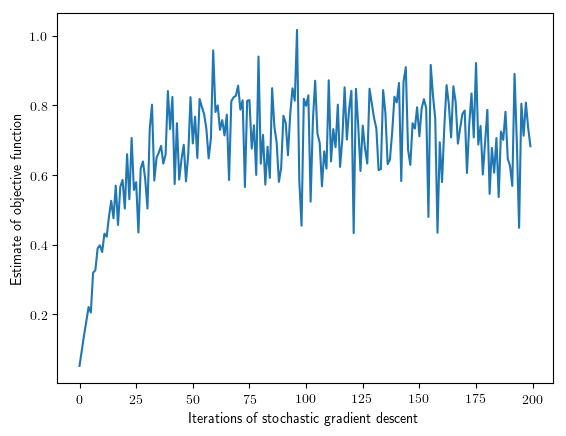

In [66]:
plot(scores)
xlabel("Iterations of stochastic gradient descent")
ylabel("Estimate of expected conditional log probability density");

We can read out the new value for `score_high`:

In [67]:
println(exp(Gen.get_param(custom_dest_proposal_trainable, :log_score_high)))

9.305638475887493


We see that the optimal value of the parameter is indeed larger than our initial guess. This validates that the heuristic is indeed a useful one. We visualize the proposal distribution below:

In [68]:
visualize_custom_destination_proposal(measurements, start, custom_dest_proposal_trainable, num_samples=1000)

<!----> <!----><!----><!---->

We can visualize the results of inference, using this newly trained proposal:

In [71]:
visualize_data_driven_inference(measurements, scene, start, custom_dest_proposal_trainable,
    amt_computation=5, samples=1000)

<!----> <!----><!----><!---->

------------
### Exercise

Can you devise a data-driven proposal for the speed of the agent? Do you expect it to work equally well on all data sets? You do not need to implement it.

### Solution

----------------

## 4. Writing and training a deep learning based data-driven proposal

The heuristic data-driven proposal above gave some improvement in efficiency, but it was very simple. One way of constructing complex data-driven proposals is to parametrize the proposal with a deep neural network or use another class of high-capacity machine learning model (e.g. random forest). Here, we will will write a data-driven proposal for the destination of the agent that uses deep neural networks.

First, we define a sigmoid function for the nonlinearity in our networks.

In [72]:
nonlinearity(x) = 1.7159 * tanh.(x * 0.66666);

We will use a deep neural network with two hidden layers that takes as input x- and y- coordinates of the first and last measurement (4 values) and produces as output a vector of un-normalized probabilities, one for each bin of the x-dimension. We will later sample `:dest_x` from this distribution.

In [73]:
function dest_x_neural_net(nn_params, x_first::Real, y_first::Real, x_last::Real, y_last::Real)
    (W1, b1, W2, b2, W3, b3) = nn_params
    input_layer = [x_first, y_first, x_last, y_last]
    hidden_layer_1 = nonlinearity(W1 * input_layer .+ b1)
    hidden_layer_2 = nonlinearity(W2 * hidden_layer_1 .+ b2)
    output_layer = exp.(W3 * hidden_layer_2 .+ b3)
    return output_layer
end;

After sampling the value of `:dest_x`, we will use a second deep neural network that takes as input the same four values extracted from the measurements, as well as the sampled value of `:dest_x` (a total of 5 inputs), and produces a vector of un-normalized probabilities, one for each bin of the y-dimension. We will sample `:dest_y` from this distribution.

In [74]:
function dest_y_neural_net(nn_params, x_first::Real, y_first::Real, x_last::Real, y_last::Real)#, dest_x::Real)
    (W1, b1, W2, b2, W3, b3) = nn_params
    input_layer = [x_first, y_first, x_last, y_last]#, dest_x]
    hidden_layer_1 = nonlinearity(W1 * input_layer .+ b1)
    hidden_layer_2 = nonlinearity(W2 * hidden_layer_1 .+ b2)
    output_layer = exp.(W3 * hidden_layer_2 .+ b3)
    return output_layer
end;

Now that we have defined our neural networks, we define our new proposal. This generative function has a number of parameters.

In [89]:
scale_coord(coord, min, max) = (coord / (max - min)) - 0.5

@gen function custom_dest_proposal_neural(measurements::Vector{Point}, scene::Scene)
        
    @param x_W1::Matrix{Float64}
    @param x_b1::Vector{Float64}
    @param x_W2::Matrix{Float64}
    @param x_b2::Vector{Float64}
    @param x_W3::Matrix{Float64}
    @param x_b3::Vector{Float64}
    
    @param y_W1::Matrix{Float64}
    @param y_b1::Vector{Float64}
    @param y_W2::Matrix{Float64}
    @param y_b2::Vector{Float64}
    @param y_W3::Matrix{Float64}
    @param y_b3::Vector{Float64}
    
    num_x_bins = length(x_b3)
    num_y_bins = length(y_b3)
    
    # scale inputs to be in the range [-0.5, 0.5]
    x_first = scale_coord(measurements[1].x, scene.xmin, scene.xmax)
    x_last = scale_coord(measurements[end].x, scene.xmin, scene.xmax)
    y_first = scale_coord(measurements[1].y, scene.ymin, scene.ymax)
    y_last = scale_coord(measurements[end].y, scene.ymin, scene.ymax)
    
    # sample dest_x
    x_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_x_bins+1))
    x_probs = dest_x_neural_net((x_W1, x_b1, x_W2, x_b2, x_W3, x_b3), x_first, y_first, x_last, y_last)
    @addr(Gen.piecewise_uniform(x_bounds, x_probs / sum(x_probs)), :dest_x)
    
    # sample dest_y
    y_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_y_bins+1))
    y_probs = dest_y_neural_net((y_W1, y_b1, y_W2, y_b2, y_W3, y_b3), x_first, y_first, x_last, y_last)
    @addr(Gen.piecewise_uniform(y_bounds, y_probs / sum(y_probs)), :dest_y)
    
    return nothing
end;

We will use 50 hidden units in each of the layers of the two networks:

In [96]:
num_hidden_1 = 50
num_hidden_2 = 50;

Next, we initialize the parameters:

In [200]:
import Random
Random.seed!(3)

init_weight(shape...) = (1. / sqrt(shape[2])) * randn(shape...)

init_x_W1 = init_weight(num_hidden_1, 4)
init_x_W2 = init_weight(num_hidden_2, num_hidden_1)
init_x_W3 = init_weight(num_x_bins, num_hidden_2)

# set parameters for dest_x_neural_net predictor network
init_param!(custom_dest_proposal_neural, :x_W1, init_x_W1)
init_param!(custom_dest_proposal_neural, :x_b1, zeros(num_hidden_1))
init_param!(custom_dest_proposal_neural, :x_W2, init_x_W2)
init_param!(custom_dest_proposal_neural, :x_b2, zeros(num_hidden_2))
init_param!(custom_dest_proposal_neural, :x_W3, init_x_W3)
init_param!(custom_dest_proposal_neural, :x_b3, zeros(num_x_bins))

init_y_W1 = init_weight(num_hidden_1, 4)
init_y_W2 = init_weight(num_hidden_2, num_hidden_1)
init_y_W3 = init_weight(num_x_bins, num_hidden_2)

# set parameters for dest_y_neural_net predictor network
init_param!(custom_dest_proposal_neural, :y_W1, init_y_W1)
init_param!(custom_dest_proposal_neural, :y_b1, zeros(num_hidden_1))
init_param!(custom_dest_proposal_neural, :y_W2, init_y_W2)
init_param!(custom_dest_proposal_neural, :y_b2, zeros(num_hidden_2))
init_param!(custom_dest_proposal_neural, :y_W3, init_y_W3)
init_param!(custom_dest_proposal_neural, :y_b3, zeros(num_y_bins));

Now, we visualize the proposal distribution prior to training:

In [201]:
visualize_custom_destination_proposal(measurements, start, custom_dest_proposal_neural, num_samples=1000)

<!----> <!----><!----><!---->

It looks like the initial distribution is roughly uniform, like the default proposal.

Now we train the network stochastic gradient descent with a fixed step size of 0.001 that is shared among all of the trainable parameters.

In [100]:
update = Gen.ParamUpdate(Gen.FixedStepGradientDescent(0.001), custom_dest_proposal_neural);

We use 100 epochs. In each epoch, we generate 1000 training examples, and we apply 100 gradient updates, where each update is based on the gradient estimate obtained from a random set of 100 of the trainable examples. At the end of each epoch, we estimate the objective function value using 10000 freshly sampled examples. This process takes about 10 minutes to run, so we have precomputed the results for you.

```julia
@time scores = Gen.train!(custom_dest_proposal_neural, data_generator, update,
    num_epoch=100, epoch_size=1000, num_minibatch=100, minibatch_size=100,
    evaluation_size=1000, verbose=true);
    
let data = Dict()
    for name in [:x_W1, :x_b1, :x_W2, :x_b2, :x_W3, :x_b3, :y_W1, :y_b1, :y_W2, :y_b2, :y_W3, :y_b3]
        data[(:param, name)] = Gen.get_param(custom_dest_proposal_neural, name)
    end
    data[:scores] = scores
    save("custom_dest_proposal_neural_trained.jld", "data", data)
end
```

We load the results here:

In [140]:
scores = let data = load("custom_dest_proposal_neural_trained.jld", "data")
    for name in [:x_W1, :x_b1, :x_W2, :x_b2, :x_W3, :x_b3, :y_W1, :y_b1, :y_W2, :y_b2, :y_W3, :y_b3]
        Gen.init_param!(custom_dest_proposal_neural, name, data[(:param, name)])
    end
    data[:scores]
end;

We plot the estimate of the objective function over epochs:

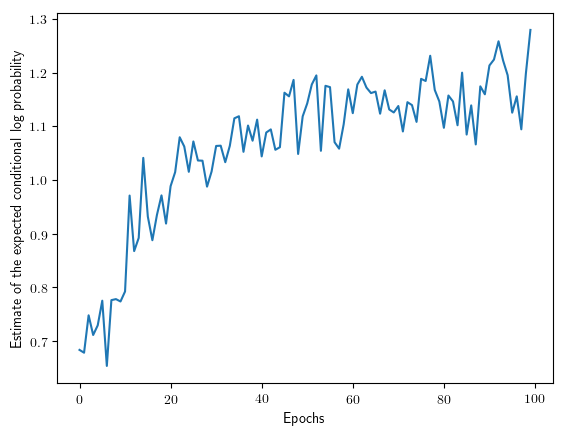

In [143]:
plot(scores)
xlabel("Epochs")
ylabel("Estimate of the expected conditional log probability density");

Below, we visualize the trained proposal distribution for our data set:

In [144]:
visualize_custom_destination_proposal(measurements, start, custom_dest_proposal_neural, num_samples=1000)

<!----> <!----><!----><!---->

If we run inference with `amt_computation` set to 5, we see that the inferred distribution reflects the bias of the proposal:

In [150]:
visualize_data_driven_inference(measurements, scene, start, custom_dest_proposal_neural,
    amt_computation=5, samples=1000)

<!----> <!----><!----><!---->

As we increase the amount of computation, the affect of the proposal's bias is reduced:

In [151]:
visualize_data_driven_inference(measurements, scene, start, custom_dest_proposal_neural,
    amt_computation=50, samples=1000)

<!----> <!----><!----><!---->

In the limit of infinite computation, the distribution converges to the posterior:

In [152]:
visualize_data_driven_inference(measurements, scene, start, custom_dest_proposal_neural,
    amt_computation=250, samples=1000)

<!----> <!----><!----><!---->

------

### Exercise

Visualize the trained proposal distribution `custom_dest_proposal_neural` on some other data sets, either generated by simulating from the model, or constructed manually. Discuss the results.

### Solution

In [147]:
new_meas = [Point(0.4, 0.1), Point(0.6, 0.35)]
visualize_custom_destination_proposal(new_meas, new_meas[1], custom_dest_proposal_neural, num_samples=1000)

<!----> <!----><!----><!---->

------------

## 6. Writing a data-driven proposal that uses TensorFlow <a name="tf"></a>

The data-driven neural proposal above used Julia code to implement the neural network. It is also possible to implement the neural networks in TensorFlow using the [GenTF](https://github.com/probcomp/GenTF) package that was introduced in a previous tutorial. We load GenTF, [PyCall](https://github.com/JuliaPy/PyCall.jl), and we import the TensorFlow Python module: 

In [153]:
using GenTF
using PyCall
@pyimport tensorflow as tf

┌ Info: Recompiling stale cache file /home/marcoct/.julia/compiled/v1.0/GenTF/SOJOY.ji for GenTF [1956f2fc-1631-11e9-1597-3d3589996c0f]
└ @ Base loading.jl:1190


Now, we implement the neural network that generate sthe parameters of the distribution of `:dest_x` as a `GenTF.TFFunction`, which is a type of generative function that is constructed from a TensorFlow computation graph.

In [205]:
vec_to_mat(vec) = tf.expand_dims(vec, axis=1)
mat_to_vec(mat) = tf.squeeze(mat, axis=1)

c1 = tf.constant(1.7159, dtype=tf.float64)
c2 = tf.constant(0.6666, dtype=tf.float64)
tf_nonlinearity(val) = tf.scalar_mul(c1, tf.tanh(tf.scalar_mul(c2, val)))

# use TensorFlow Python API to construct computation graph for the dest_x neural network
x_W1 = tf.get_variable("x_W1", dtype=tf.float64, initializer=init_x_W1)
x_b1 = tf.get_variable("x_b1", dtype=tf.float64, initializer=zeros(num_hidden_1))
x_W2 = tf.get_variable("x_W2", dtype=tf.float64, initializer=init_x_W2)
x_b2 = tf.get_variable("x_b2", dtype=tf.float64, initializer=zeros(num_hidden_2))
x_W3 = tf.get_variable("x_W3", dtype=tf.float64, initializer=init_x_W3)
x_b3 = tf.get_variable("x_b3", dtype=tf.float64, initializer=zeros(num_x_bins))
x_nn_input = tf.placeholder(dtype=tf.float64, shape=(4,))
x_nn_hidden_1 = tf_nonlinearity(tf.add(mat_to_vec(tf.matmul(x_W1, vec_to_mat(x_nn_input))), x_b1))
x_nn_hidden_2 = tf_nonlinearity(tf.add(mat_to_vec(tf.matmul(x_W2, vec_to_mat(x_nn_hidden_1))), x_b2))
x_nn_output = tf.exp(tf.add(mat_to_vec(tf.matmul(x_W3, vec_to_mat(x_nn_hidden_2))), x_b3))

# construct a TFFunction generative function for the x neural network
x_nn = GenTF.TFFunction([x_W1, x_b1, x_W2, x_b2, x_W3, x_b3], [x_nn_input], x_nn_output);

We do the same for the neural network that generates the y-coordinates:

In [206]:
# use TensorFlow Python API to construct computation graph for the dest_y neural network
y_W1 = tf.get_variable("y_W1", dtype=tf.float64, initializer=init_y_W1)
y_b1 = tf.get_variable("y_b1", dtype=tf.float64, initializer=zeros(num_hidden_1))
y_W2 = tf.get_variable("y_W2", dtype=tf.float64, initializer=init_y_W2)
y_b2 = tf.get_variable("y_b2", dtype=tf.float64, initializer=zeros(num_hidden_2))
y_W3 = tf.get_variable("y_W3", dtype=tf.float64, initializer=init_y_W3)
y_b3 = tf.get_variable("y_b3", dtype=tf.float64, initializer=zeros(num_y_bins))
y_nn_input = tf.placeholder(dtype=tf.float64, shape=(4,))
y_nn_hidden_1 = tf_nonlinearity(tf.add(mat_to_vec(tf.matmul(y_W1, vec_to_mat(y_nn_input))), y_b1))
y_nn_hidden_2 = tf_nonlinearity(tf.add(mat_to_vec(tf.matmul(y_W2, vec_to_mat(y_nn_hidden_1))), y_b2))
y_nn_output = tf.exp(tf.add(mat_to_vec(tf.matmul(y_W3, vec_to_mat(y_nn_hidden_2))), y_b3))

# construct a TFFunction generative function for the y neural network
y_nn = TFFunction([y_W1, y_b1, y_W2, y_b2, y_W3, y_b3], [y_nn_input], y_nn_output);

Next, we define a `@gen` function that invokes the two neural network `TFFunction`s and actually samples the proposed values.

In [207]:
@gen function custom_dest_proposal_tf(measurements::Vector{Point}, scene::Scene)
        
    # scale inputs to be in the range [-0.5, 0.5]
    x_first = scale_coord(measurements[1].x, scene.xmin, scene.xmax)
    x_last = scale_coord(measurements[end].x, scene.xmin, scene.xmax)
    y_first = scale_coord(measurements[1].y, scene.ymin, scene.ymax)
    y_last = scale_coord(measurements[end].y, scene.ymin, scene.ymax)
    
    # sample dest_x
    x_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_x_bins+1))
    x_probs = @addr(x_nn([x_first, y_first, x_last, y_last]), :x_net)
    dest_x = @addr(Gen.piecewise_uniform(x_bounds, x_probs / sum(x_probs)), :dest_x)
    
    # sample dest_y
    y_bounds = collect(range(scene.ymin, stop=scene.ymax, length=num_y_bins+1))
    y_probs = @addr(y_nn([x_first, y_first, x_last, y_last]), :y_net)
    @addr(Gen.piecewise_uniform(y_bounds, y_probs / sum(y_probs)), :dest_y)
    
    return nothing
end;

To train the proposal, we construct an update that applies a fixed step size gradient descent move. We indicate that we want the update to apply to all the trainable parameters of `x_nn` and all the trainable parameters of `y_nn`. Note that `custom_dest_proposal_tf` does not have any trainable parameters of its own, unlike `custom_dest_proposal_neural`.

In [208]:
update = Gen.ParamUpdate(Gen.FixedStepGradientDescent(0.001),
    x_nn => collect(get_params(x_nn)), y_nn => collect(get_params(y_nn)));

Finally, we train it:

In [210]:
@time scores = Gen.train!(custom_dest_proposal_tf, data_generator, update,
    num_epoch=100, epoch_size=1000, num_minibatch=100, minibatch_size=100,
    evaluation_size=1000, verbose=true);

epoch 1: generating 1000 training examples...
epoch 1: training using 100 minibatches of size 100...
epoch 1: evaluating on 1000 examples...
epoch 1: est. objective value: 0.6703424857855875
epoch 2: generating 1000 training examples...
epoch 2: training using 100 minibatches of size 100...
epoch 2: evaluating on 1000 examples...
epoch 2: est. objective value: 0.7064199009246144
epoch 3: generating 1000 training examples...
epoch 3: training using 100 minibatches of size 100...
epoch 3: evaluating on 1000 examples...
epoch 3: est. objective value: 0.656764858403259
epoch 4: generating 1000 training examples...
epoch 4: training using 100 minibatches of size 100...
epoch 4: evaluating on 1000 examples...


InterruptException: InterruptException:

In [ ]:
plot(scores)

We visualize the distribution after training:

In [ ]:
visualize_custom_destination_proposal(measurements, start, custom_dest_proposal_tf, num_samples=1000)

--------

### Exercise

For good peformance on a GPU it is often desirable to vectorize the evaluation of gradients across multiple training examples. Write a "batched" version of the `custom_dest_proposal_tf`, called `batched_dest_proposal_tf`, that takes a scene and a vector of data sets (measurement vectors), and samples a destination point for each of the input data sets.

### Solution

In [286]:
tf.reset_default_graph()

In [287]:
c1 = tf.constant(1.7159, dtype=tf.float64)
c2 = tf.constant(0.6666, dtype=tf.float64)
tf_nonlinearity_vec(val) = tf.scalar_mul(c1, tf.tanh(tf.scalar_mul(c2, val)))

# use TensorFlow Python API to construct computation graph for the dest_x neural network
x_W1 = tf.get_variable("x_W1_vec", dtype=tf.float64, initializer=init_x_W1)
x_b1 = tf.get_variable("x_b1_vec", dtype=tf.float64, initializer=zeros(num_hidden_1))
x_W2 = tf.get_variable("x_W2_vec", dtype=tf.float64, initializer=init_x_W2)
x_b2 = tf.get_variable("x_b2_vec", dtype=tf.float64, initializer=zeros(num_hidden_2))
x_W3 = tf.get_variable("x_W3_vec", dtype=tf.float64, initializer=init_x_W3)
x_b3 = tf.get_variable("x_b3_vec", dtype=tf.float64, initializer=zeros(num_x_bins))
x_nn_input = tf.placeholder(dtype=tf.float64, shape=(nothing, 4)) # nothing indicates 'unknown dimension'
x_nn_hidden_1 = tf_nonlinearity_vec(tf.add(tf.einsum("jk,ik->ij", x_W1, x_nn_input), x_b1))
x_nn_hidden_2 = tf_nonlinearity_vec(tf.add(tf.einsum("jk,ik->ij", x_W2, x_nn_hidden_1), x_b2))
x_nn_output = tf.exp(tf.add(tf.einsum("jk,ik->ij", x_W3, x_nn_hidden_2), x_b3))

# construct a TFFunction generative function for the x neural network
x_nn_vec = GenTF.TFFunction([x_W1, x_b1, x_W2, x_b2, x_W3, x_b3], [x_nn_input], x_nn_output);

# use TensorFlow Python API to construct computation graph for the dest_x neural network
y_W1 = tf.get_variable("y_W1_vec", dtype=tf.float64, initializer=init_y_W1)
y_b1 = tf.get_variable("y_b1_vec", dtype=tf.float64, initializer=zeros(num_hidden_1))
y_W2 = tf.get_variable("y_W2_vec", dtype=tf.float64, initializer=init_y_W2)
y_b2 = tf.get_variable("y_b2_vec", dtype=tf.float64, initializer=zeros(num_hidden_2))
y_W3 = tf.get_variable("y_W3_vec", dtype=tf.float64, initializer=init_y_W3)
y_b3 = tf.get_variable("y_b3_vec", dtype=tf.float64, initializer=zeros(num_y_bins))
y_nn_input = tf.placeholder(dtype=tf.float64, shape=(nothing, 4)) # nothing indicates 'unknown dimension'
y_nn_hidden_1 = tf_nonlinearity_vec(tf.add(tf.einsum("jk,ik->ij", y_W1, y_nn_input), y_b1))
y_nn_hidden_2 = tf_nonlinearity_vec(tf.add(tf.einsum("jk,ik->ij", y_W2, y_nn_hidden_1), y_b2))
y_nn_output = tf.exp(tf.add(tf.einsum("jk,ik->ij", y_W3, y_nn_hidden_2), y_b3))

# construct a TFFunction generative function for the y neural network
y_nn_vec = TFFunction([y_W1, y_b1, y_W2, y_b2, y_W3, y_b3], [y_nn_input], y_nn_output);

In [288]:
function scale_inputs(measurements::Vector{Point}, scene::Scene)
    x_first = scale_coord(measurements[1].x, scene.xmin, scene.xmax)
    x_last = scale_coord(measurements[end].x, scene.xmin, scene.xmax)
    y_first = scale_coord(measurements[1].y, scene.ymin, scene.ymax)
    y_last = scale_coord(measurements[end].y, scene.ymin, scene.ymax)
    return [x_first, x_last, x_first, y_last]
end

@gen function custom_dest_proposal_tf_vectorized(measurements::Vector{Vector{Point}}, scene::Scene)
    
    n = length(measurements)

    # construct inputs to the vectorized neural networks
    nn_input = Matrix{Float64}(undef, n, 4)
    for i=1:n
        nn_input[i,:] = scale_inputs(measurements[i], scene)
    end

    # compute probability distribution on x bins for all data sets
    x_probs = @addr(x_nn_vec(nn_input), :x_net)
    @assert size(x_probs) == (n, num_x_bins)
    
    # sample the x destinations
    x_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_x_bins+1))
    for i=1:n
        @addr(Gen.piecewise_uniform(x_bounds, x_probs[i,:] / sum(x_probs[i,:])), (:dest_x, i))
    end
    
    # compute probability distribution on y bins for all data sets
    y_probs = @addr(y_nn_vec(nn_input), :y_net)
    @assert size(y_probs) == (n, num_y_bins)
    
    # sample the y destinations
    y_bounds = collect(range(scene.ymin, stop=scene.ymax, length=num_y_bins+1))
    for i=1:n
        @addr(Gen.piecewise_uniform(y_bounds, y_probs[i,:] / sum(y_probs[i,:])), (:dest_y, i))
    end
    
    return nothing
end;

In [289]:
batch_size = 100

function data_generator_vectorized()
    
    # obtain an execution of the model where planning succeeded
    all_measurements = Vector{Vector{Point}}(undef, batch_size)
    constraints = Gen.DynamicAssignment()
    for example=1:batch_size
        done = false
        while !done
            (assmt, _, retval) = Gen.propose(agent_model, (scene, dt, num_ticks, planner_params))
            (planning_failed, maybe_path) = retval       
            done = !planning_failed
        end
        all_measurements[example] = [Point(assmt[:meas => (i, :x)], assmt[:meas => (i, :y)]) for i=1:num_ticks]
        constraints[(:dest_x, example)] = assmt[:dest_x]
        constraints[(:dest_y, i)] = assmt[:dest_y]
    end

    # construct arguments to the proposal function being trained
    inputs = (all_measurements, scene)
    
    return ((inputs), constraints)
end;

In [290]:
update_tf_vectorized = Gen.ParamUpdate(Gen.FixedStepGradientDescent(0.001),
    x_nn_vec => collect(get_params(x_nn_vec)), y_nn_vec => collect(get_params(y_nn_vec)));

In [291]:
function new_train!(gen_fn::GenerativeFunction, data_generator::Function,
                update::ParamUpdate;
                num_epoch=1, epoch_size=1, num_minibatch=1, minibatch_size=1,
                evaluation_size=epoch_size, eval_period=1, verbose=false)

    history = Vector{Float64}()
    for epoch=1:num_epoch

        # generate data for epoch
        if verbose
            println("epoch $epoch: generating $epoch_size training examples...")
        end
        tstart = time_ns()
        epoch_inputs = Vector{Tuple}(undef, epoch_size)
        epoch_assmts = Vector{Assignment}(undef, epoch_size)
        for i=1:epoch_size
            (epoch_inputs[i], epoch_assmts[i]) = data_generator()
        end
        if verbose
            elapsed = time_ns() - tstart
            println("$(elapsed / 1e9) s")
        end
            
        # train on epoch data
        if verbose
            println("epoch $epoch: training using $num_minibatch minibatches of size $minibatch_size...")
        end
        tstart = time_ns()
        for minibatch=1:num_minibatch
            permuted = Random.randperm(epoch_size)
            minibatch_idx = permuted[1:minibatch_size]
            minibatch_inputs = epoch_inputs[minibatch_idx]
            minibatch_assmts = epoch_assmts[minibatch_idx]
            for (inputs, constraints) in zip(minibatch_inputs, minibatch_assmts)
                (trace, _) = initialize(gen_fn, inputs, constraints)
                retval_grad = accepts_output_grad(gen_fn) ? zero(get_retval(trace)) : nothing
                backprop_params(trace, retval_grad)
            end
            apply!(update)
        end
        if verbose
            elapsed = time_ns() - tstart
            println("$(elapsed / 1e9) s")
        end
        
        # evaluate score on held out data
        if epoch % eval_period == 0
            if verbose
                println("epoch $epoch: evaluating on $evaluation_size examples...")
            end
            tstart = time_ns()
            avg_score = 0.
            for i=1:evaluation_size
                (inputs, constraints) = data_generator()
                (_, weight) = initialize(gen_fn, inputs, constraints)
                avg_score += weight
            end
            avg_score /= evaluation_size
            if verbose
                elapsed = time_ns() - tstart
                println("$(elapsed / 1e9) s")
            end

            push!(history, avg_score)

            if verbose
                println("epoch $epoch: est. objective value: $avg_score")
            end
        end
    end
    return history
end


new_train! (generic function with 1 method)

In [ ]:
@time scores = new_train!(custom_dest_proposal_tf_vectorized, data_generator_vectorized, update_tf_vectorized,
    num_epoch=10000, epoch_size=1, num_minibatch=10, minibatch_size=1,
    evaluation_size=10, eval_period=100, verbose=true);

In [294]:
saver = tf.train[:Saver](Dict(string(var[:name]) => var for var in get_params(x_nn_vec)))
saver[:save](get_session(x_nn_vec), "/home/marcoct/x_nn_vec.ckpt")
#saver[:save](get_session(y_nn_vec), "/home/marcoct/y_nn_vec.ckpt")

"/home/marcoct/x_nn_vec.ckpt"

In [281]:
saver = tf.train[:Saver](Dict(string(var[:name]) => var for var in get_params(y_nn_vec)))
saver[:save](get_session(y_nn_vec), "/home/marcoct/y_nn_vec.ckpt")
#saver[:save](get_session(y_nn_vec), "/home/marcoct/y_nn_vec.ckpt")

"/home/marcoct/y_nn_vec.ckpt"

In [282]:
saver = tf.train[:Saver](Dict(string(var[:name]) => var for var in get_params(x_nn_vec)))
saver[:restore](get_session(x_nn_vec), "/home/marcoct/x_nn_vec.ckpt")

INFO:tensorflow:Restoring parameters from /home/marcoct/x_nn_vec.ckpt


In [295]:
saver = tf.train[:Saver](Dict(string(var[:name]) => var for var in get_params(y_nn_vec)))
saver[:restore](get_session(y_nn_vec), "/home/marcoct/y_nn_vec.ckpt")

INFO:tensorflow:Restoring parameters from /home/marcoct/y_nn_vec.ckpt


Now, we also write a non-vectorized version of the proposal, for use in importance sampling.

In [296]:
@gen function custom_dest_proposal_tf_nonvectorized(measurements::Vector{Point}, scene::Scene)
    
    # construct inputs to the vectorized neural networks
    nn_input = Matrix{Float64}(scale_inputs(measurements, scene)')
    @assert size(nn_input) == (1, 4)

    # compute probability distribution on x bin
    x_probs = @addr(x_nn_vec(nn_input), :x_net)[1,:]
    @assert size(x_probs) == (num_x_bins,)
    
    # sample the x destinations
    x_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_x_bins+1))
    @addr(Gen.piecewise_uniform(x_bounds, x_probs / sum(x_probs)), :dest_x)
    
    # compute probability distribution on y bins for all data sets
    y_probs = @addr(y_nn_vec(nn_input), :y_net)[1,:]
    @assert size(y_probs) == (num_y_bins,)
    
    # sample the y destinations
    y_bounds = collect(range(scene.ymin, stop=scene.ymax, length=num_y_bins+1))
    @addr(Gen.piecewise_uniform(y_bounds, y_probs / sum(y_probs)), :dest_y)
    
    return nothing
end;

In [297]:
visualize_custom_destination_proposal(measurements, start, custom_dest_proposal_tf_nonvectorized, num_samples=1000)

<!----> <!----><!----><!---->